In [1]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display

from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.policies import policy_saver
from utils import preprocess_data, create_wide_format_data, SYMBOLS
from environment import CryptoTradingEnvironment


# Data and Model Paths
DATA_FILEPATH = 'data/ohlcv.csv.gz'
POLICY_SAVE_PATH = 'policy'

# Model Hyperparameters
CONTEXT_LENGTH = 10
NUM_TRAINING_STEPS = 10000  # Increased for more meaningful training
ALPHA = 1.0 # LinUCB exploration parameter

# 1. Load Data
df = pd.read_csv(DATA_FILEPATH, compression='gzip', parse_dates=['timestamp']) #.set_index('timestamp')
all_data = preprocess_data(df)
observation_df, prices_df = create_wide_format_data(
    all_data, 
    symbols=SYMBOLS, 
    features=['rsi']
)

# 2. Setup Environment
crypto_env = CryptoTradingEnvironment(
    observation_df=observation_df,
    prices_df=prices_df,
    symbols=SYMBOLS
)

tf_env = tf_py_environment.TFPyEnvironment(crypto_env)

# 3. Setup Agent
agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec=tf_env.time_step_spec(),
    action_spec=tf_env.action_spec(),
    alpha=ALPHA,
    dtype=tf.float32
)

# 4. Setup Metrics and Oracle
def optimal_reward_oracle(observation: np.ndarray) -> np.float32:
    """
    Calculates the best possible reward for the current step by looking ahead.
    This "perfect foresight" oracle is used for calculating regret.

    NOTE: The 'observation' argument is unused but required by the metric's API.
    """
    
    # 2. Get the current step index from the environment's state.
    current_step = crypto_env.current_step
    price_data = crypto_env.price_data
    
    # 3. Handle the edge case where we are at the end of the data.
    # We can't look one step into the future.
    if current_step >= len(price_data) - 1:
        return 0.0

    # 4. Calculate the reward for every possible action to find the maximum.
    all_possible_rewards = []
    num_actions = crypto_env.action_spec().maximum + 1
    
    for action in range(num_actions):
        # Decode the action into a symbol and a trade type
        crypto_index = action // 3
        trade_type_idx = action % 3  # 0: BUY, 1: HOLD, 2: SELL
        
        # The reward for a HOLD action is always 0.
        if trade_type_idx == 1:
            all_possible_rewards.append(0.0)
            continue
            
        symbol_to_trade = crypto_env.symbols[crypto_index]
        
        current_price = price_data.iloc[current_step][symbol_to_trade]
        next_price = price_data.iloc[current_step + 1][symbol_to_trade]
        
        # Calculate the reward for this specific BUY or SELL action
        if trade_type_idx == 0:  # BUY
            reward = (next_price - current_price) / current_price
        else:  # SELL (trade_type_idx == 2)
            reward = (current_price - next_price) / current_price
        
        all_possible_rewards.append(reward)
        
    # 5. Return the maximum possible reward from all actions.
    return np.max(all_possible_rewards).astype(np.float32)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_oracle)

class ShowProgress:
    def __init__(self, total, interval=50):
        self.counter = 0
        self.total = total
        self.interval = interval
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % self.interval == 0:
            print("\r{}/{} Reward: {}".format(self.counter, self.total, np.round(trajectory.reward.numpy()[0], 6)), end="")

class RewardCollector():
    def __init__(self):
        self._rewards = []
    def __call__(self, trajectory):
        self._rewards.append(trajectory.reward[0])
    @property
    def rewards(self):
        return np.array(self._rewards)

# 5. Setup Driver
def train_step(trajectory):
    if not trajectory.is_last():
        time_axised_trajectory = tf.nest.map_structure(lambda t: tf.expand_dims(t, 1), trajectory)
        agent.train(time_axised_trajectory)
        
num_steps = NUM_TRAINING_STEPS - CONTEXT_LENGTH - 5

reward_collector = RewardCollector()

driver = dynamic_step_driver.DynamicStepDriver(
    env=tf_env,
    policy=agent.policy,
    num_steps=num_steps,
    observers=[train_step, regret_metric, ShowProgress(num_steps), reward_collector]
)

# 6. Run Training
print(f"\nStarting training for {driver._num_steps} steps...")
driver.run()
print("\nTraining finished.")

# 7. Save Policy
print(f"\nSaving the trained policy to: {POLICY_SAVE_PATH}")
saver = policy_saver.PolicySaver(agent.policy)
saver.save(POLICY_SAVE_PATH)
print("Policy saved successfully.")

# 8. Report Results
cumulative_regret = regret_metric.result().numpy()
print(f"\nCumulative Regret vs. Perfect Foresight Oracle: {cumulative_regret:.4f}")

2025-07-16 18:51:18.434459: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 18:51:18.461072: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-16 18:51:18.461091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-16 18:51:18.461820: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-16 18:51:18.466240: I tensorflow/core/platform/cpu_feature_guar

Converting data to wide format for observations and prices...
Wide format conversion complete.


2025-07-16 18:51:20.108549: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-16 18:51:20.114047: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-16 18:51:20.115579: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-


Starting training for 9985 steps...
9950/9985 Reward: 0.00051400001393631161
Training finished.

Saving the trained policy to: policy


INFO:tensorflow:Assets written to: policy/assets


/usr/local/lib/python3.11/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: policy/assets


Policy saved successfully.

Cumulative Regret vs. Perfect Foresight Oracle: 0.0152


Text(0.5, 0, 'Number of Iterations')

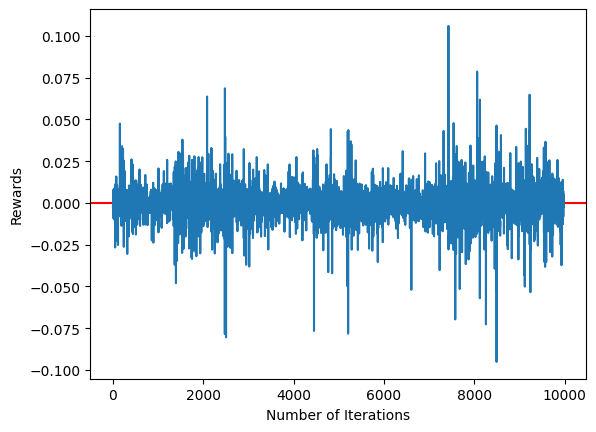

In [2]:
import matplotlib.pyplot as plt

rewards = reward_collector.rewards
average_reward = rewards.mean()

plt.axhline(y=average_reward, color='r', linestyle='-')
plt.plot(rewards)
plt.ylabel('Rewards')
plt.xlabel('Number of Iterations')